# Notebook 0: generate plots

Generate panels that will be used to construct Fig. 4 in the manuscript.

In [1]:
import toytree
import ipcoal
import numpy as np

# print versions
print("ipcoal", ipcoal.__version__)
print("toytree", toytree.__version__)

ipcoal 0.4.dev5
toytree 3.0.1


### Get example data 
Returns a species tree, embedded genealogy, and dict mapping species tree tips to genealogy tips.

In [29]:
SPTREE, GTREE, IMAP = ipcoal.msc.get_test_data()

### Visualize the embedding

In [33]:
ipcoal.draw.draw_embedded_genealogy(SPTREE, GTREE, IMAP);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="td1cae84611214e9caa73a1cd8609058e"> idx=5
Ne=1e+05
Tc=1
Tg=2e+05 idx=3
Ne=1e+05
Tc=3
Tg=6e+05 idx=4
Ne=1e+05
Tc=1
Tg=2e+05 idx=2
Ne=1e+05
Tc=2
Tg=4e+05 idx=0
Ne=1e+05
Tc=1
Tg=2e+05 idx=1
Ne=1e+05
Tc=1
Tg=2e+05 idx=6
Ne=1e+05
Tc=0
Tg=0 0 1 2 3 4 5 6 node=0 node=1 node=2 node=7 node=3 node=4 node=8 node=5 node=6 node=9 node=10 node=11 node=12 0 250000 500000 750000

### Get embedding table

In [34]:
ipcoal.smc.get_genealogy_embedding_table(SPTREE, GTREE, IMAP)

,start,stop,st_node,neff,nedges,dist,gidx,edges
0,0.0,100000.0,0,100000.0,3,100000.0,0,"[0, 1, 2]"
1,100000.0,200000.0,0,100000.0,2,100000.0,0,"[2, 7]"
2,0.0,120000.0,1,100000.0,2,120000.0,0,"[3, 4]"
3,120000.0,200000.0,1,100000.0,1,80000.0,0,[8]
4,0.0,400000.0,2,100000.0,1,400000.0,0,[5]
5,0.0,600000.0,3,100000.0,1,600000.0,0,[6]
6,200000.0,300000.0,4,100000.0,3,100000.0,0,"[2, 7, 8]"
7,300000.0,400000.0,4,100000.0,2,100000.0,0,"[7, 9]"
8,400000.0,450000.0,5,100000.0,3,50000.0,0,"[5, 7, 9]"
9,450000.0,600000.0,5,100000.0,2,150000.0,0,"[5, 10]"


### Generate figures
A general function is available for visualizing edge probabilities in `ipcoal`. This is used to generate the plots for supplementary figure S2.

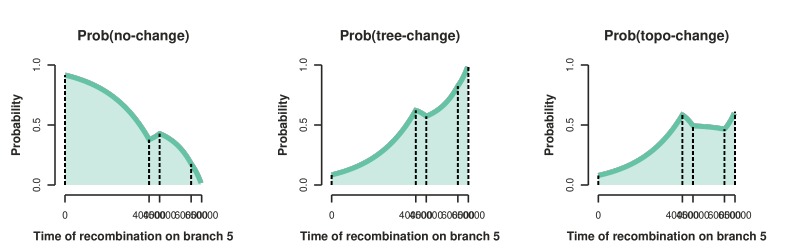

In [35]:
ipcoal.smc.plot_edge_probabilities(
    species_tree=SPTREE,
    genealogy=GTREE,
    imap=IMAP,
    branch=5,
    stack=0,
)

### Custom function for Fig. 1

To generate figure panels for Figure 1 of the manuscript we use the function below and then used Inkscape to combine and further color the plots.

In [36]:
from typing import Sequence, Dict
import toyplot, toyplot.svg
from ipcoal.smc.src.ms_smc_tree_prob import *
from ipcoal.smc.src.ms_smc_topo_prob import *

In [49]:
def plot_edge_probabilities(
    species_tree: toytree.ToyTree,
    genealogy: toytree.ToyTree,
    imap: Dict[str, Sequence[str]],
    branch: int,
    etype: str,
    **kwargs,
) -> toyplot.canvas.Canvas:
    """Return a toyplot canvas with probabilities along an edge.
    
    Plot probability of an event type (no-change, tree-change, topo-change) over an edge.
    """
    canvas = toyplot.Canvas(height=kwargs.get("height", 250), width=kwargs.get("width", 800),)
    ax0 = canvas.cartesian(margin=65, padding=0)

    # Select a branch to plot and get its relations
    branch = genealogy[branch]
    bidx = branch.idx
    sidx = branch.get_sisters()[0].idx
    pidx = branch.up.idx

    # Get genealogy embedding table
    emb, enc = get_genealogy_embedding_arrays(species_tree, genealogy, imap)
    
    # Plot probabilities of change types over a single branch
    times = np.linspace(branch.height, branch.up.height, 200, endpoint=False)
    
    # get probabilities
    pt_nochange_tree = [
        get_prob_tree_unchanged_given_b_and_tr_from_arrays(
        emb[0], enc[0], bidx, itime) for itime in times
    ]
    pt_nochange_topo = [
        get_prob_topo_unchanged_given_b_and_tr_from_arrays(
        emb[0], enc[0], bidx, sidx, pidx, itime) for itime in times
    ]

    # add line and fill for probabilities
    if etype == "no-change":
        ax0.fill(times, pt_nochange_tree, opacity=0.7)
    elif etype == "tree-change":
        ax0.fill(times, 1 - np.array(pt_nochange_tree), opacity=0.7)
    elif etype == "topo-change":
        ax0.fill(times, 1 - np.array(pt_nochange_topo), opacity=0.7)
    else:
        raise ValueError("etype arg not recognized")

    # style the axes
    ax1 = ax0.share('y', ymax=1.0, ymin=0)
    ax1.x.ticks.locator = toyplot.locator.Explicit(list(emb[0, :, 0]))
    ax1.x.domain.min = 0
    ax1.x.domain.max = gtree[-1].height
    ax1.x.domain.show = ax1.y.domain.show = False
    ax1.x.ticks.show = ax1.y.ticks.show = True
    ax1.x.ticks.far = ax1.y.ticks.far = 0
    ax1.x.ticks.near = ax1.y.ticks.near = 7.5
    #ax1.x.ticks.labels.offset = ax1.y.ticks.labels.offset = 15
    #ax1.x.label.text = f"Time of event (generations)"
    #ax1.label.offset = 20
    ax1.x.ticks.labels.show = False
    ax1.y.label.text = "Probability"
    
    ax1.x.label.offset = ax0.y.label.offset = 35
    ax1.x.spine.style['stroke-width'] = ax0.y.spine.style['stroke-width'] = 5
    ax1.x.ticks.style['stroke-width'] = ax0.y.ticks.style['stroke-width'] = 5
    
    ax1.y.ticks.locotor = toyplot.locator.Explicit([0, 0.5, 1.0])
    ax0.x.spine.style["stroke-width"] = 5
    ax0.x.domain.min = 0
    ax0.x.domain.max = gtree[-1].height
    ax0.x.domain.show = False
    ax0.x.ticks.labels.show = False
    return canvas, ax0


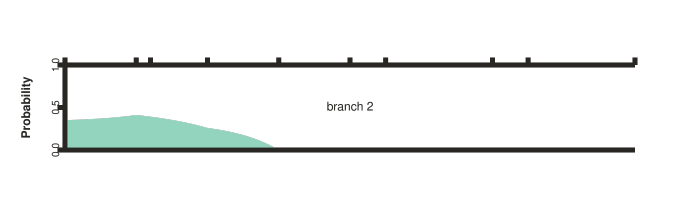

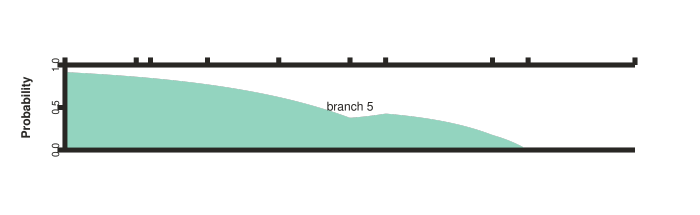

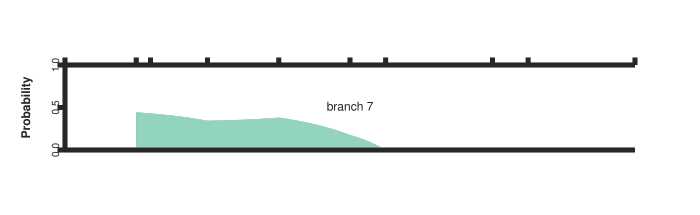

In [50]:
for branch in [2, 5, 7]:
    canvas, axes = plot_edge_probabilities(SPTREE, GTREE, IMAP, branch=branch, etype="no-change", width=700, height=215)
    canvas.text(canvas.width / 2, canvas.height / 2, f"branch {branch}")
    #toyplot.svg.render(canvas, f"../manuscript/figures/panels/prob-no-change-branch-{branch}.svg")
    display(canvas)

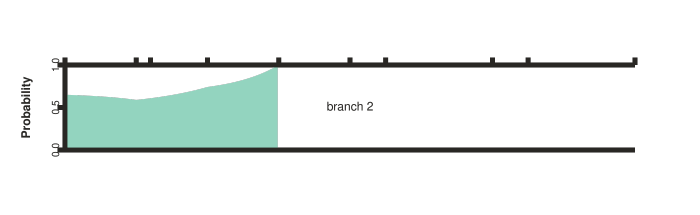

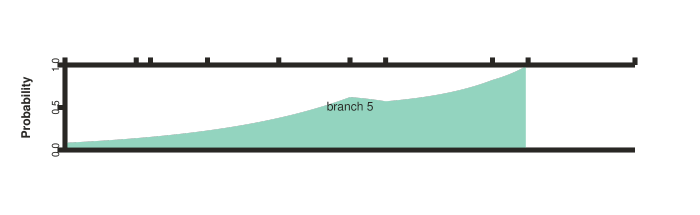

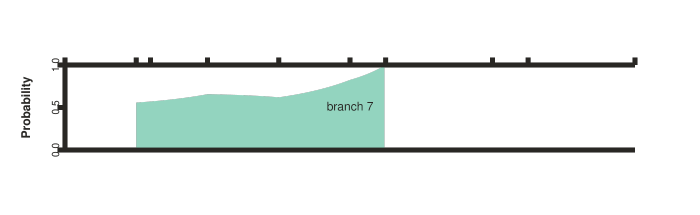

In [52]:
for branch in [2, 5, 7]:
    canvas, axes = plot_edge_probabilities(SPTREE, GTREE, IMAP, branch=branch, etype="tree-change", width=700, height=215)
    canvas.text(canvas.width / 2, canvas.height / 2, f"branch {branch}")
    #toyplot.svg.render(canvas, f"../manuscript/figures/panels/prob-tree-change-branch-{branch}.svg")
    display(canvas)

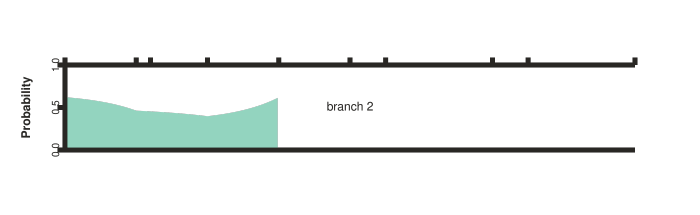

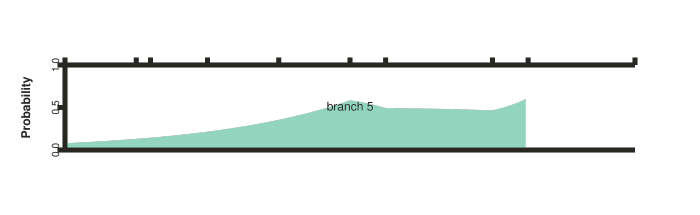

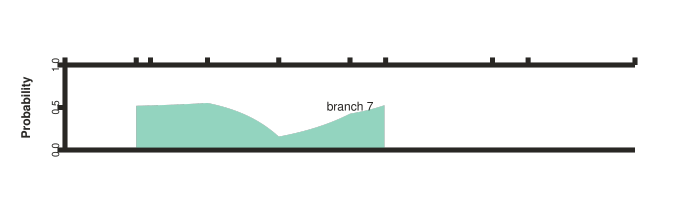

In [53]:
for branch in [2, 5, 7]:
    canvas, axes = plot_edge_probabilities(SPTREE, GTREE, IMAP, branch=branch, etype="topo-change", width=700, height=215)
    canvas.text(canvas.width / 2, canvas.height / 2, f"branch {branch}")
    toyplot.svg.render(canvas, f"../manuscript/figures/panels/prob-topo-change-branch-{branch}.svg")
    display(canvas)